In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

all_df = pd.read_csv('TrainDataset2024.csv', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


In [2]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

In [3]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def mad_based_outlier(points, threshold=3.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:, None]
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    # Small constant added to avoid division by zero
    modified_z_scores = [0.6745 * (y - median_y) / (median_absolute_deviation_y + 1e-6) for y in points]

    return np.abs(modified_z_scores) > threshold

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if abs(val - mean)/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutliers(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = func(x)
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(20, 15)

def removeOutliers(data):
    # Remove outliers from the dataframe
    for column in data.columns:
        outliers = outlierVote(all_df[column])
        # Calculate Non-Outlier Maximum using the outliers list
        non_outlier_max = all_df.loc[~np.array(outliers), column].max()
        # Replace outliers with the maximum non-outlier value
        data.loc[outliers, column] = non_outlier_max

removeOutliers(all_df)
# Verify the changes
all_df.head()

# Assign features to X
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

<ipython-input-8-187a2ed57fde>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


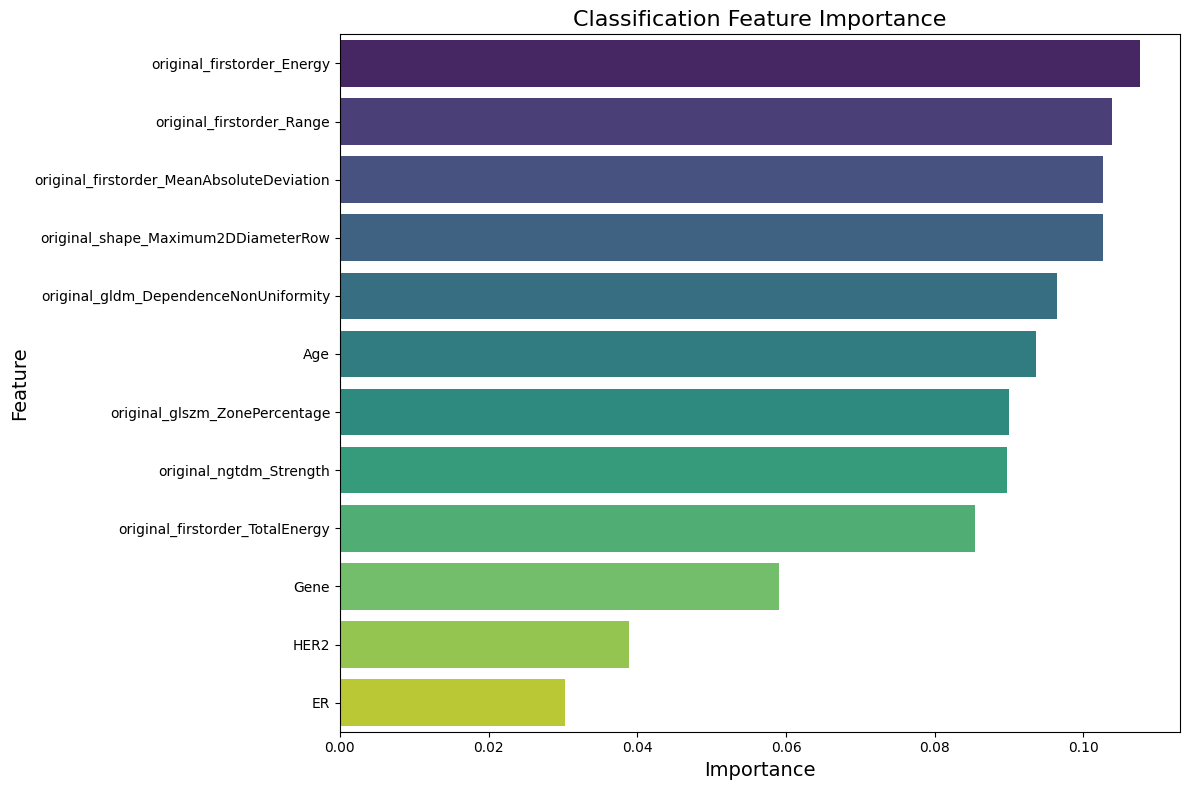

In [8]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Define features to retain
retain_features = ['ER', 'HER2', 'Gene']

# Filter Method: SelectKBest
# Classification target
clf_selector = SelectKBest(score_func=mutual_info_classif, k=10)
clf_selector.fit(X, clf_y)
clf_selected_features = X.columns[clf_selector.get_support()]

# Regression target
rgr_selector = SelectKBest(score_func=f_classif, k=10)
rgr_selector.fit(X, rgr_y)
rgr_selected_features = X.columns[rgr_selector.get_support()]

# Add retained features
clf_selected_features = list(set(clf_selected_features).union(retain_features))
rgr_selected_features = list(set(rgr_selected_features).union(retain_features))

# Wrapper Method: RFE
# Classification target
clf_model = RandomForestClassifier(random_state=42)
clf_rfe = RFE(estimator=clf_model, n_features_to_select=10, step=1)
clf_rfe.fit(X[clf_selected_features], clf_y)
clf_rfe_features = list(X[clf_selected_features].columns[clf_rfe.support_])

# Regression target
rgr_model = RandomForestRegressor(random_state=42)
rgr_rfe = RFE(estimator=rgr_model, n_features_to_select=10, step=1)
rgr_rfe.fit(X[rgr_selected_features], rgr_y)
rgr_rfe_features = list(X[rgr_selected_features].columns[rgr_rfe.support_])

# Add retained features to final selected lists
final_clf_features = list(set(clf_rfe_features).union(retain_features))
final_rgr_features = list(set(rgr_rfe_features).union(retain_features))

def plot_feature_importance(features, importances, title="Feature Importance"):
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Classification Feature Importance
clf_model.fit(X[final_clf_features], clf_y)  # Train classifier on final selected features
clf_importances = clf_model.feature_importances_
plot_feature_importance(final_clf_features, clf_importances, title="Classification Feature Importance")



Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6788 - loss: 0.6196 - val_accuracy: 0.8000 - val_loss: 0.4857
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8051 - loss: 0.4033 - val_accuracy: 0.8000 - val_loss: 0.4778
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7842 - loss: 0.4444 - val_accuracy: 0.8000 - val_loss: 0.4667
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8215 - loss: 0.4004 - val_accuracy: 0.8000 - val_loss: 0.4601
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7963 - loss: 0.4533 - val_accuracy: 0.7875 - val_loss: 0.4663
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7933 - loss: 0.4019 - val_accuracy: 0.8125 - val_loss: 0.4770
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8143 - loss: 0.3764 - val_accuracy: 0.8000 - val_loss: 0.4860
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8191 - loss: 0.3652 - val_accuracy: 0.8000 - val_loss: 0.

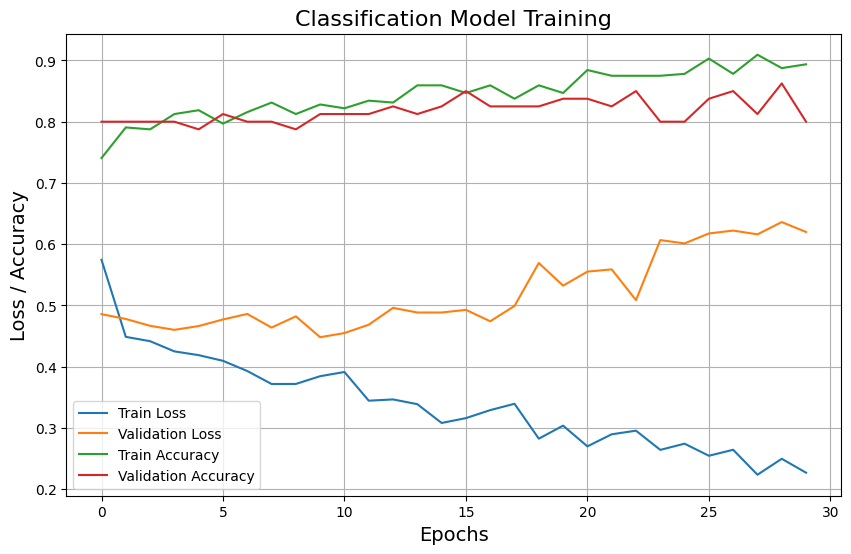

In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Standardize data
scaler = StandardScaler()
X_clf = scaler.fit_transform(X[final_clf_features])

# Split data into train and test sets
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, clf_y,test_size=0.2, random_state=42)

# Build the DNN model for classification
def build_classification_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the model
clf_model = build_classification_model(X_clf_train.shape[1])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
clf_history = clf_model.fit(X_clf_train, y_clf_train,
                            validation_data=(X_clf_test, y_clf_test),
                            epochs=200,
                            batch_size=32,
                            callbacks=[early_stopping],
                            verbose=1)

# Evaluate the model on the test set
clf_eval = clf_model.evaluate(X_clf_test, y_clf_test)
print(f"Classification Model - Loss: {clf_eval[0]:.4f}, Accuracy: {clf_eval[1]:.4f}")

# Plot training history
def plot_training_history(history, title="Classification Model Training"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss / Accuracy', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize training and validation performance
plot_training_history(clf_history)
